organize plume analysis: plume ablation process (speed up), plume scatter process (cool down and slow down), plume landing process (can't observe for the most of the deposition)

then provide evaluation summary between condition, label outliers

find approach to detect the target position, start from observe the target position for outlier plume

from Liyan:

1. target surface effect
2. target position effect
3. condition mapping

In [20]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('../../plume_dynamic_analyzer/src/')
from analyzer.plume_utils import remove_all_0_plume
from analyzer.PlumeDataset import plume_dataset

sys.path.append('../../py-utils/src/')
from viz import show_images, label_violinplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 100 mTorr, 1.6 J/cm^2 for multiple growth

Analyze plume: Seperate the plume into several stages: surface ablation, plume transport, plume landing.

### show example plumes

['1-SrRuO3', '1-SrRuO3_Pre']
(380, 128, 250, 400)


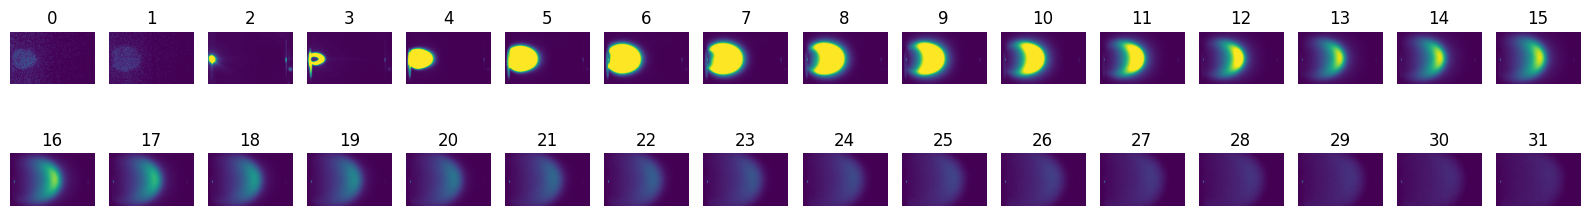

In [2]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
print(keys)
plumes = plume_ds.load_plumes('1-SrRuO3')
print(plumes.shape)

show_images(plumes[0][:32], img_per_row=16)

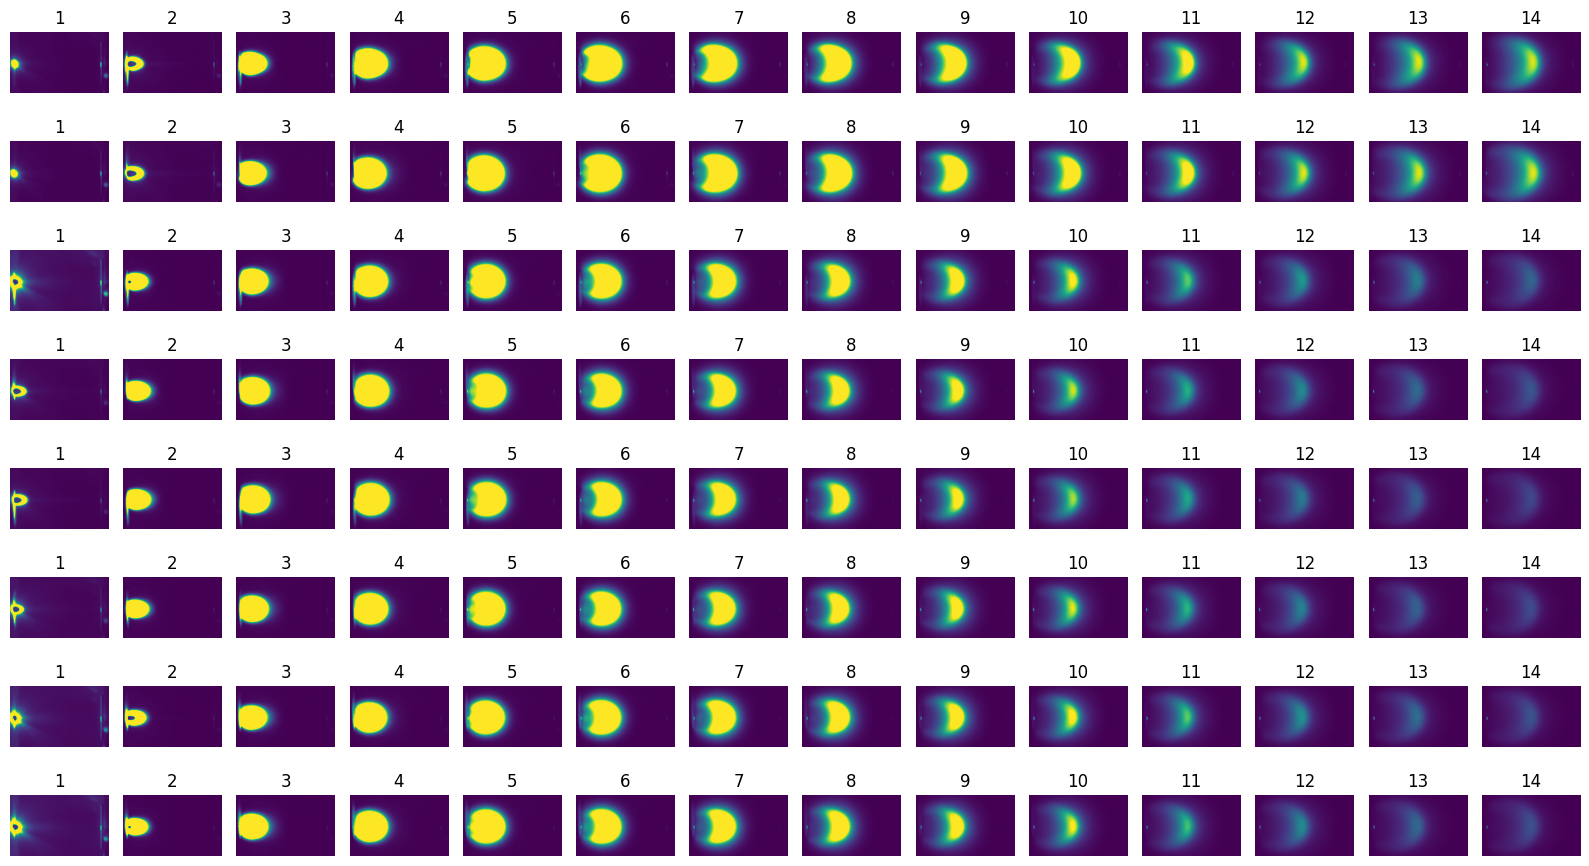

In [5]:
plumes_target = plumes[::50, 2:16]
labels = list(range(1, plumes_target.shape[1]+1))*len(plumes_target)

plumes_target = plumes_target.reshape(plumes_target.shape[0]*plumes_target.shape[1], plumes_target.shape[2], plumes_target.shape[3])
show_images(plumes_target, img_per_row=14, labels=labels)

### load plume data

In [21]:
df_condition = pd.read_excel('../../data/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[27, 34, 35, 36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('700 (heater N)', 700, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition.sample(5)


Growth  Pressure (mTorr)  Temperature (C)  Fluence (J/cm2)  \
34  YG063             100.0              700              1.6   
27  YG056             100.0              700              1.6   
36  YG065             100.0              700              1.6   
39  YG068             100.0              700              1.6   
37  YG066             100.0              700              1.6   

    Repetation rate (Hz)  
34                   5.0  
27                   5.0  
36                   5.0  
39                   5.0  
37                   5.0

In [25]:
df_frame_metrics = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../data/Plumes/SRO_plume_metrics/{key}*metrics.csv')[0]
    # print(file)
    df = pd.read_csv(file, index_col=0)
    df['Threshold'].astype(str)
    df = df[df['Threshold']=='200']
    df = remove_all_0_plume(df.reset_index(), metric='Area', viz=False)
    df_frame_metrics.append(df)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics.sample(8)

plume_index  time_index  Distance  Velocity  Area Threshold Growth
76191             3          31       234       0.0   0.0       200  YG064
58684           244          60       199       0.0   0.0       200  YG063
39148            90         108       202       0.0   0.0       200  YG063
143373          156          13       213       0.0   3.0       200  YG065
322144           29          96       212       0.0   0.0       200  YG069
249063          214         103       213       0.0   0.0       200  YG067
103985          222          49       232       0.0   0.0       200  YG064
80279            36          23       232       0.0   0.0       200  YG064

### viz plume_level metrics

In [46]:
# analyze the max area
df_frame_metrics_200 = df_frame_metrics[df_frame_metrics['Threshold']=='200']
idx = df_frame_metrics_200.groupby(['Growth', 'plume_index'])['Area'].idxmax()
df_max_area = df_frame_metrics_200.loc[idx, ['Growth', 'plume_index', 'time_index', 'Area']].reset_index(drop=True)
df_max_area.rename(columns={'Area': 'max_area'}, inplace=True)
df_max_area.rename(columns={'time_index': 'time_index(max_area)'}, inplace=True)
df_max_area.sample(8)

Growth  plume_index  time_index(max_area)  max_area
502   YG063          288                     6   15038.0
1965  YG067          234                     6   16158.0
616   YG064           25                     6   20345.0
1406  YG066           59                     7   16458.0
2484  YG068          381                     6   16144.0
763   YG064          173                     6   19212.0
1731  YG067            0                     6   16039.0
296   YG063           81                     6   15529.0

In [47]:
# analyze plume velocity that can be tracked before landing on the substrate
df_filtered = df_frame_metrics[(df_frame_metrics['Distance'] >= 200) & (df_frame_metrics['Distance'] <= 250)]
df_unique = df_filtered.drop_duplicates(subset=['time_index', 'Distance', 'Velocity', 'Area', 'Threshold'])
incident_velocity = df_unique.groupby(['Growth', 'plume_index'])['Velocity'].mean().reset_index()
incident_velocity.rename(columns={'Velocity': 'incident_velocity'}, inplace=True)
incident_velocity.sample(8)

Growth  plume_index  incident_velocity
2531  YG069          114       1.000000e+07
199   YG056          202       3.333333e+06
1576  YG066          294       2.000000e+06
1558  YG066          274       6.000000e+06
1520  YG066          235       3.000000e+06
647   YG064           74       1.285714e+07
1030  YG065           84       6.750000e+06
1442  YG066          145       2.000000e+06

In [49]:
df_plume_metrics = pd.merge(df_max_area, incident_velocity, on=['Growth', 'plume_index'])
df_plume_metrics.sample(8)

Growth  plume_index  time_index(max_area)  max_area  incident_velocity
594   YG064           21                     6   20263.0       1.275000e+07
2483  YG069           66                     5   15596.0       7.600000e+06
381   YG063          169                     6   14888.0       8.000000e+05
1267  YG065          325                     6   16917.0       9.333333e+06
1521  YG066          236                     6   15614.0       2.727273e+06
30    YG056           30                     6   15336.0       1.428571e+06
715   YG064          143                     7   19520.0       1.200000e+07
2607  YG069          190                     6   15995.0       8.000000e+06

#### plume max area

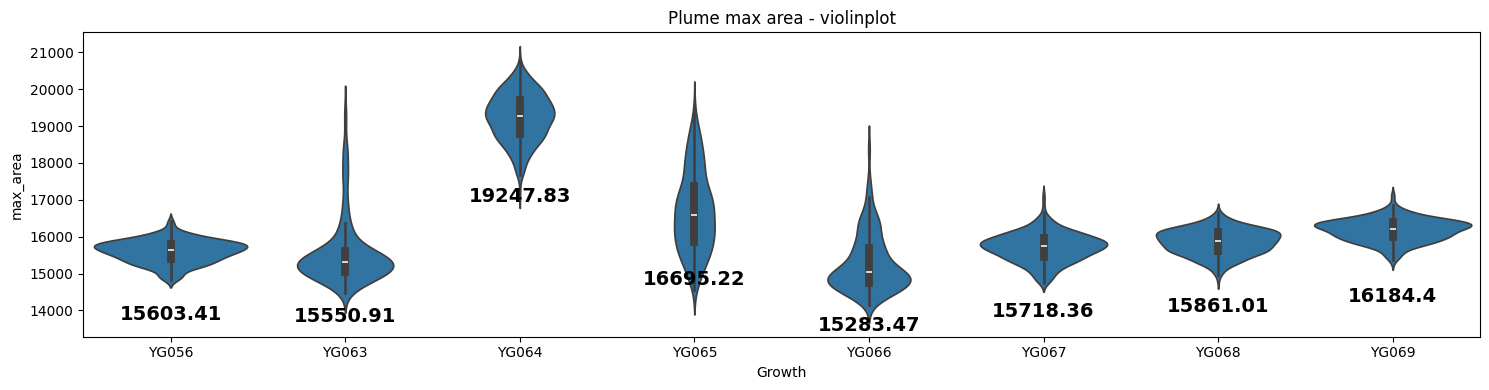

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.violinplot(x='Growth', y='max_area', data=df_plume_metrics, width=0.9, ax=ax)
mean_max_area = df_plume_metrics.groupby('Growth')['max_area'].mean()
label_violinplot(ax, mean_max_area, label_type='average', text_pos='center', 
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume max area - violinplot')
plt.tight_layout()
plt.show()

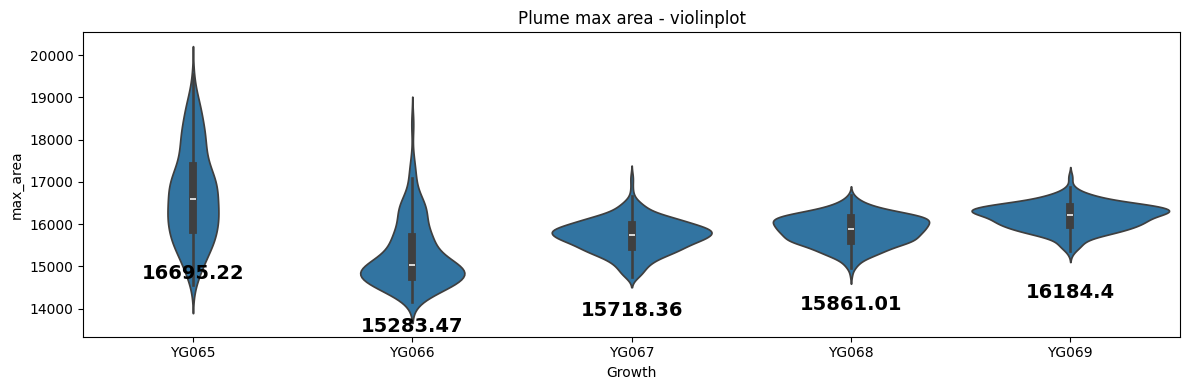

In [55]:
df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(['YG065', 'YG066', 'YG067', 'YG068', 'YG069'])]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.violinplot(x='Growth', y='max_area', data=df_plume_metrics_target, width=0.9, ax=ax)
mean_max_area = df_plume_metrics_target.groupby('Growth')['max_area'].mean()
label_violinplot(ax, mean_max_area, label_type='average', text_pos='center', 
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume max area - violinplot')
plt.tight_layout()
plt.show()

#### incident velocity

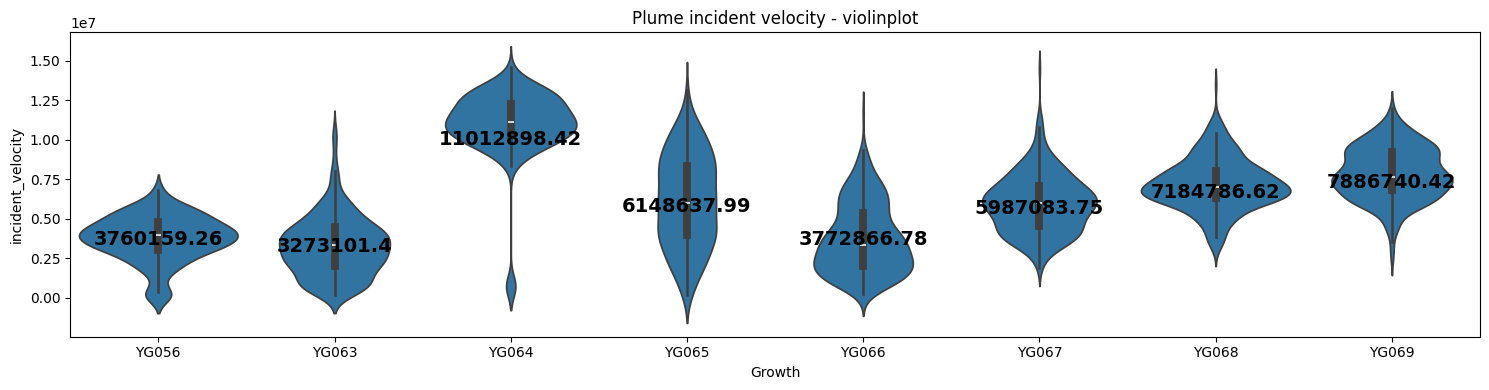

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.violinplot(x='Growth', y='incident_velocity', data=df_plume_metrics, width=0.9, ax=ax)
mean_incident_velocity = df_plume_metrics.groupby('Growth')['incident_velocity'].mean()
label_violinplot(ax, mean_incident_velocity, label_type='average', text_pos='center', 
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume incident velocity - violinplot')
plt.tight_layout()
plt.show()

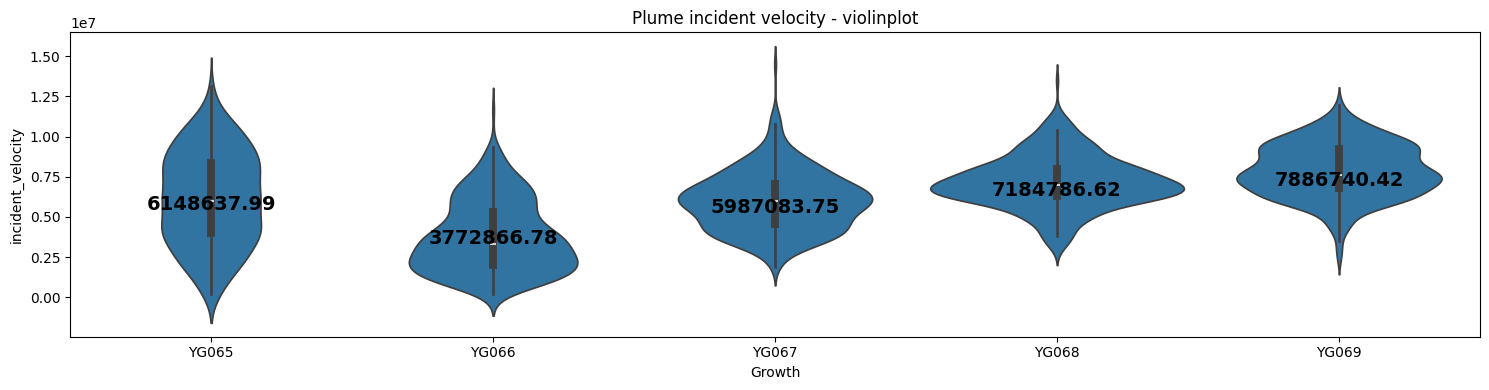

In [57]:
df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(['YG065', 'YG066', 'YG067', 'YG068', 'YG069'])]

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.violinplot(x='Growth', y='incident_velocity', data=df_plume_metrics_target, width=0.9, ax=ax)
mean_incident_velocity = df_plume_metrics_target.groupby('Growth')['incident_velocity'].mean()
label_violinplot(ax, mean_incident_velocity, label_type='average', text_pos='center', 
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume incident velocity - violinplot')
plt.tight_layout()
plt.show()

#### seperated view

In [36]:
hue_label = 'Growth'

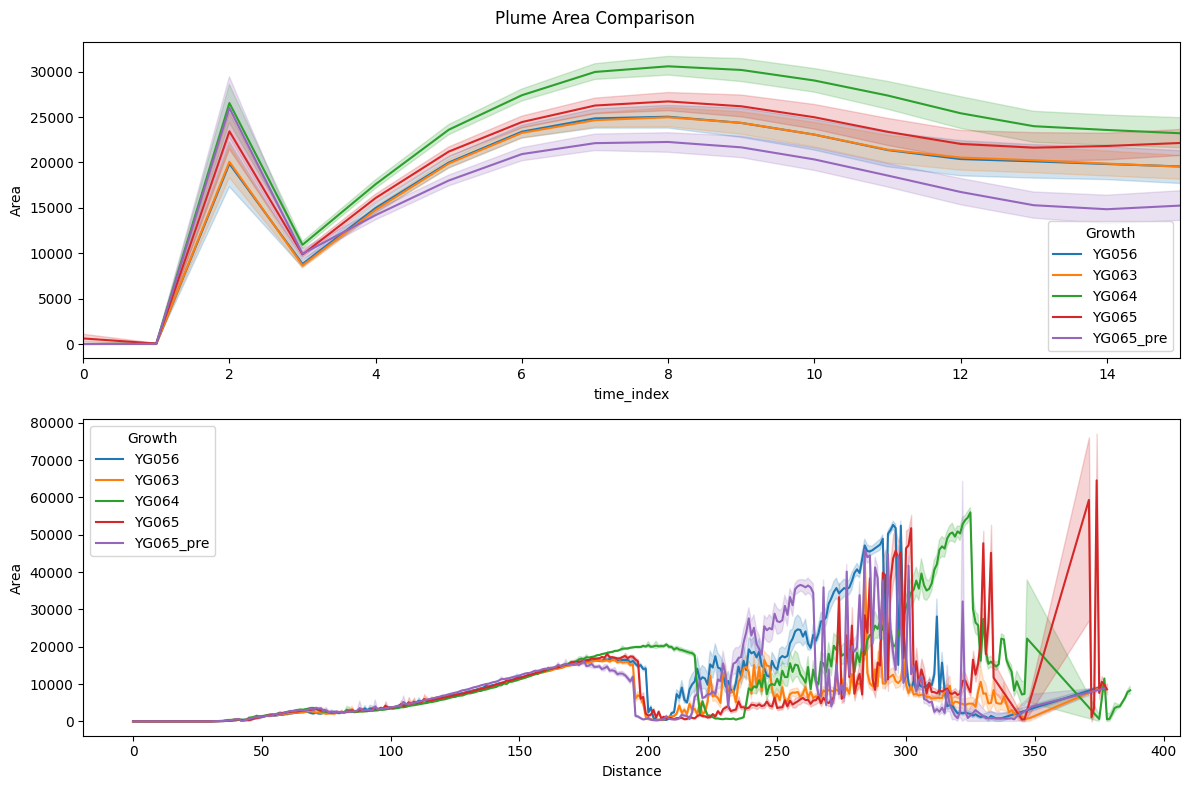

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

lineplot = sns.lineplot(x="time_index", y="Area", hue=hue_label, data=df_frame_metrics, ax=axes[0])
axes[0].set_xlim(0, 15)

lineplot = sns.lineplot(x="Distance", y="Area", hue=hue_label, data=df_frame_metrics, ax=axes[1])
plt.suptitle('Plume Area Comparison')
plt.tight_layout()
plt.show()

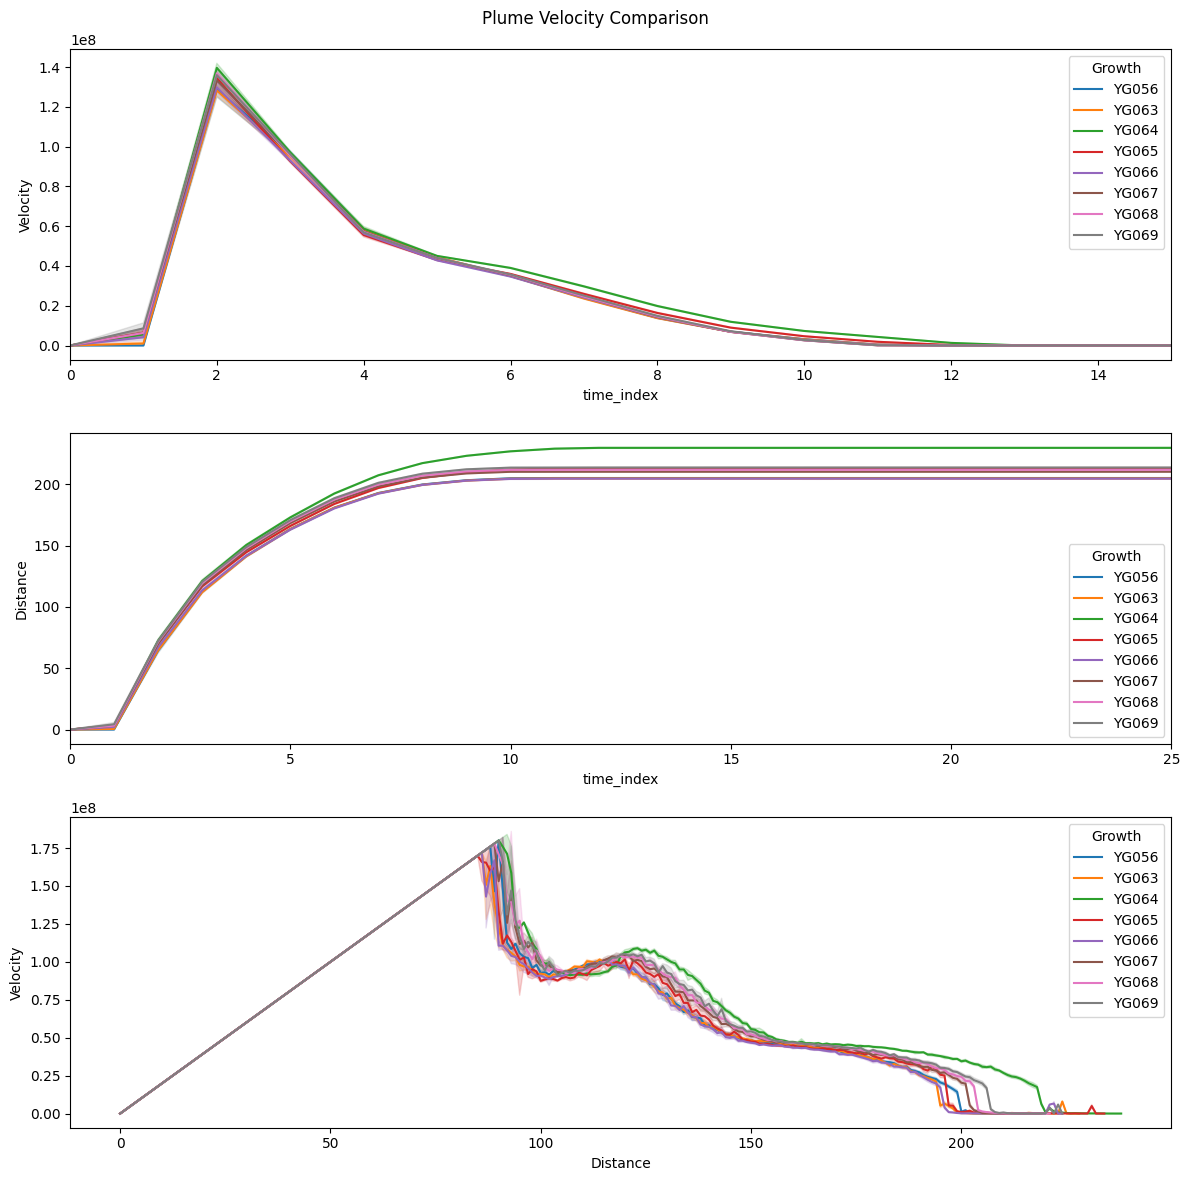

In [37]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

lineplot = sns.lineplot(x="time_index", y="Velocity", hue=hue_label, data=df_frame_metrics, ax=axes[0])
axes[0].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Distance", hue=hue_label, data=df_frame_metrics, ax=axes[1])
axes[1].set_xlim(0, 25)

lineplot = sns.lineplot(x="Distance", y="Velocity", hue=hue_label, data=df_frame_metrics, ax=axes[2])
plt.suptitle('Plume Velocity Comparison')
plt.tight_layout()
plt.show()

#### compact view

In [24]:
hue_label = 'Growth'

palette_area = [(31, 119, 180), (44, 160, 44), (214, 39, 40)] 
palette_area = [(r/255, g/255, b/255) for r, g, b in palette_area]
palette_velocity = [(174, 199, 232), (152, 223, 138), (255, 152, 150)]
palette_velocity = [(r/255, g/255, b/255) for r, g, b in palette_velocity]

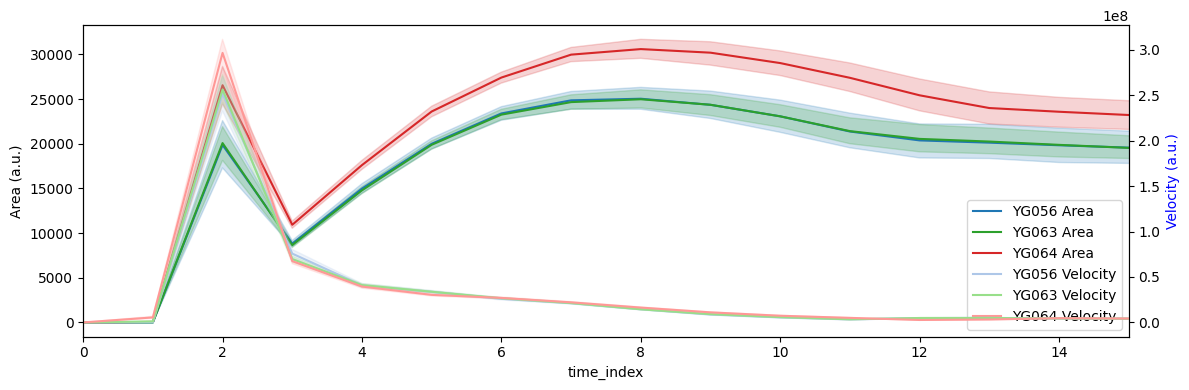

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

sns.lineplot(x="time_index", y="Area", hue=hue_label, data=df_frame_metrics, ax=ax1, palette=palette_area, legend=False)
ax1.set_xlim(0, 15)
ax1.set_ylabel('Area (a.u.)', color='k')

ax2 = ax1.twinx()
sns.lineplot(x="time_index", y="Velocity", hue=hue_label, data=df_frame_metrics, ax=ax2, palette=palette_velocity, legend=False)
ax2.set_ylabel('Velocity (a.u.)', color='b')

lines_1, labels_1 = ax1.get_lines(), ['YG056 Area', 'YG063 Area', 'YG064 Area', ]
lines_2, labels_2 = ax2.get_lines(), ['YG056 Velocity', 'YG063 Velocity', 'YG064 Velocity']
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

# Tight layout and show plot
plt.tight_layout()
plt.show()

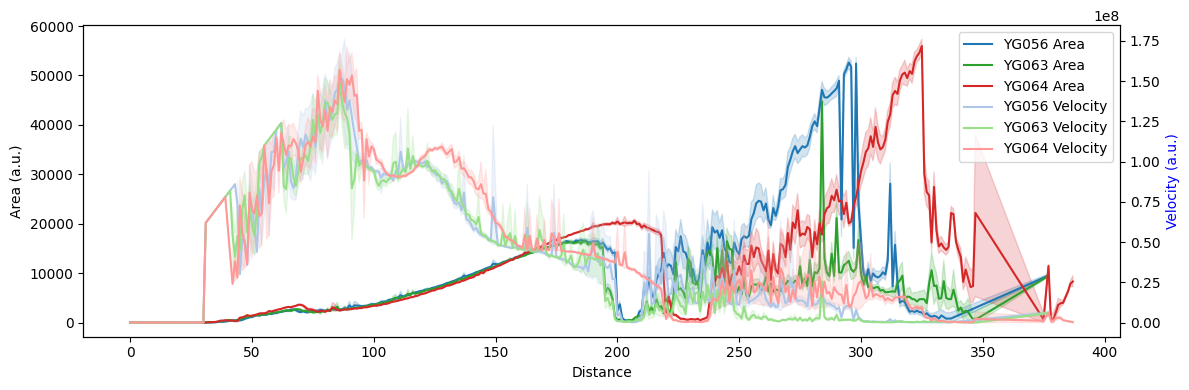

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

sns.lineplot(x="Distance", y="Area", hue=hue_label, data=df_frame_metrics, ax=ax1, palette=palette_area, legend=False)
ax1.set_ylabel('Area (a.u.)', color='k')

ax2 = ax1.twinx()
sns.lineplot(x="Distance", y="Velocity", hue=hue_label, data=df_frame_metrics, ax=ax2, palette=palette_velocity, legend=False)
ax2.set_ylabel('Velocity (a.u.)', color='b')

lines_1, labels_1 = ax1.get_lines(), ['YG056 Area', 'YG063 Area', 'YG064 Area', ]
lines_2, labels_2 = ax2.get_lines(), ['YG056 Velocity', 'YG063 Velocity', 'YG064 Velocity']
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

# Tight layout and show plot
plt.tight_layout()
plt.show()

#### zoom in view

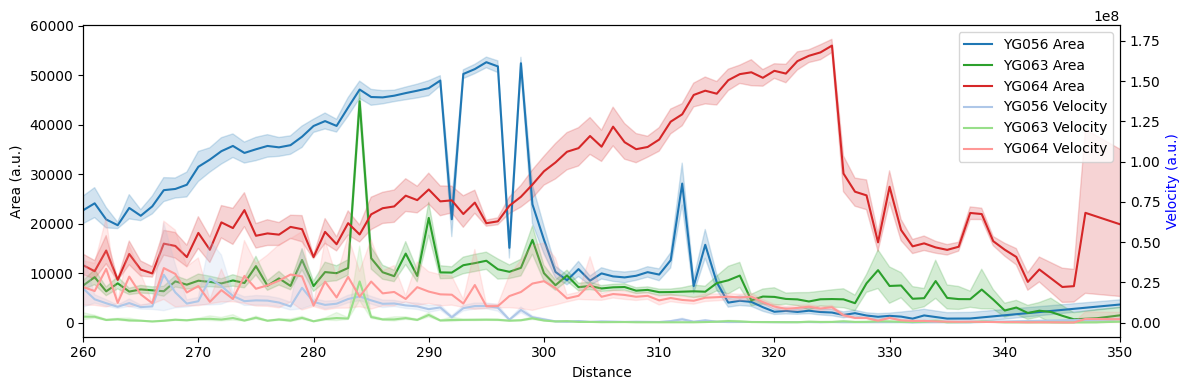

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

sns.lineplot(x="Distance", y="Area", hue=hue_label, data=df_frame_metrics, ax=ax1, palette=palette_area, legend=False)
ax1.set_xlim(260, 350)
ax1.set_ylabel('Area (a.u.)', color='k')

ax2 = ax1.twinx()
sns.lineplot(x="Distance", y="Velocity", hue=hue_label, data=df_frame_metrics, ax=ax2, palette=palette_velocity, legend=False)
ax2.set_ylabel('Velocity (a.u.)', color='b')

lines_1, labels_1 = ax1.get_lines(), ['YG056 Area', 'YG063 Area', 'YG064 Area', ]
lines_2, labels_2 = ax2.get_lines(), ['YG056 Velocity', 'YG063 Velocity', 'YG064 Velocity']
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

# Tight layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Area", hue=label, data=df_frame_metrics, ax=axes[0])
axes[0].set_xlim(6, 12)
lineplot = sns.lineplot(x="Distance", y="Area", hue=label, data=df_frame_metrics, ax=axes[1])
# axes[1].set_title('Plume Area')
axes[1].set_xlim(170, 210)
plt.suptitle('Plume Area')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue=label, data=df_frame_metrics, ax=axes[0])
axes[0].set_xlim(3, 11)
lineplot = sns.lineplot(x="Distance", y="Velocity", hue=label, data=df_frame_metrics, ax=axes[1])
axes[1].set_xlim(80, 210)
plt.suptitle('Plume Velocity')
plt.tight_layout()
plt.show()

#### violinplot

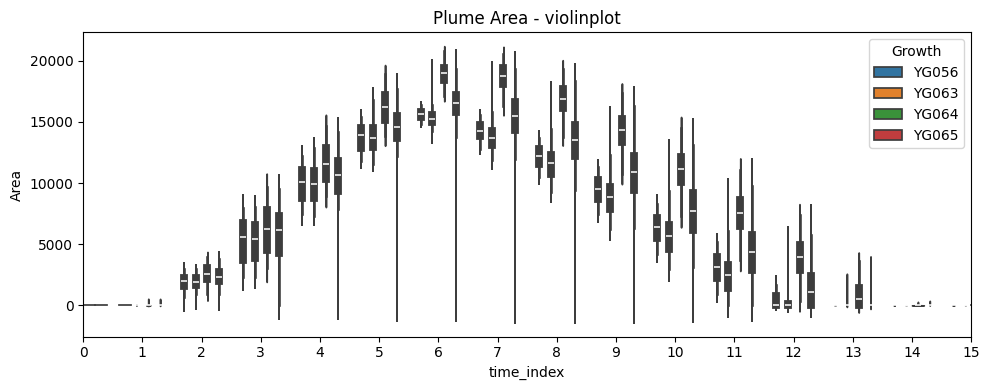

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.violinplot(x='time_index', y='Area', hue='Growth', data=df_frame_metrics[df_frame_metrics['Threshold']=='200'])
# for flier in ax.collections[::2]:
#     flier.set_alpha(0.3)
ax.set_title('Plume Area - violinplot')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

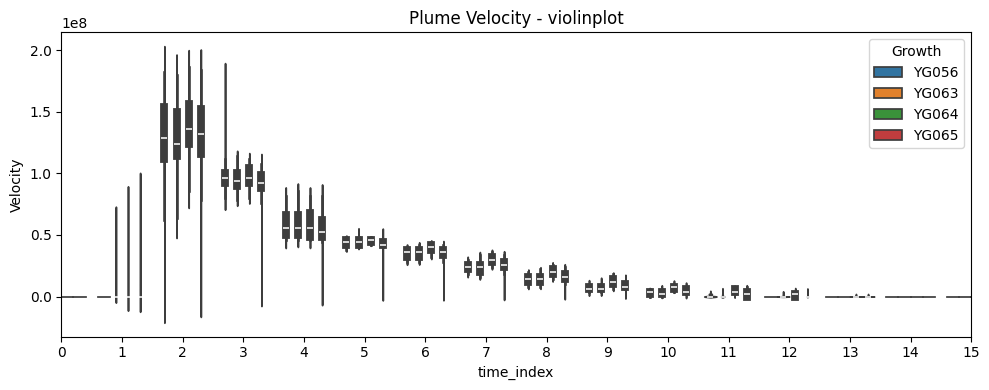

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.violinplot(x='time_index', y='Velocity', hue='Growth', data=df_frame_metrics[df_frame_metrics['Threshold']=='200'])
# for flier in ax.collections[::2]:
#     flier.set_alpha(0.3)
ax.set_title('Plume Velocity - violinplot')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

#### lineplot stability

In [46]:
df_frame_metrics_200 = df_frame_metrics[df_frame_metrics['Threshold']=='200']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

df1 = df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG056']
df1 = df1[df1['plume_index']<=15 & df1['plume_index']>=300]

lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df1, ax=ax)
ax.set_xlim(0, 15)

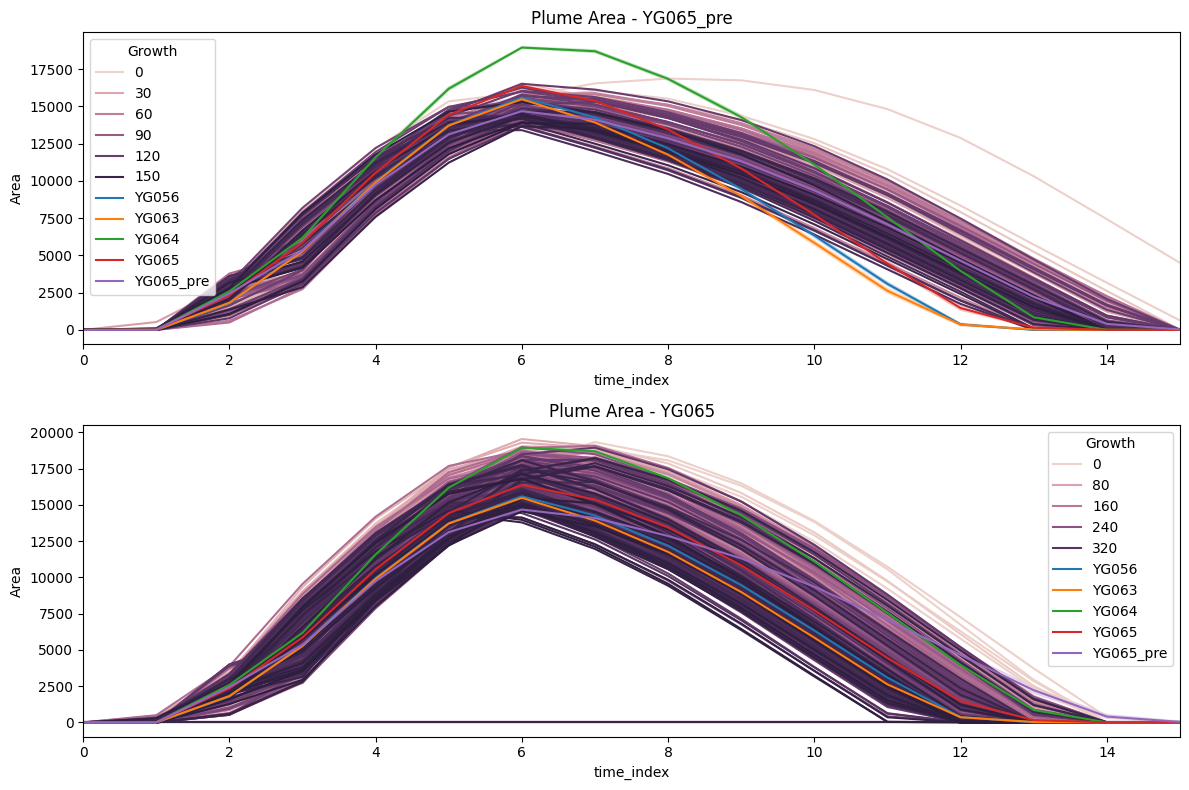

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG065_pre'], ax=axes[0])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[0])
axes[0].set_title('Plume Area - YG065_pre')
axes[0].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG065'], ax=axes[1])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[1])
axes[1].set_title('Plume Area - YG065')
axes[1].set_xlim(0, 15)

plt.tight_layout()
plt.show()

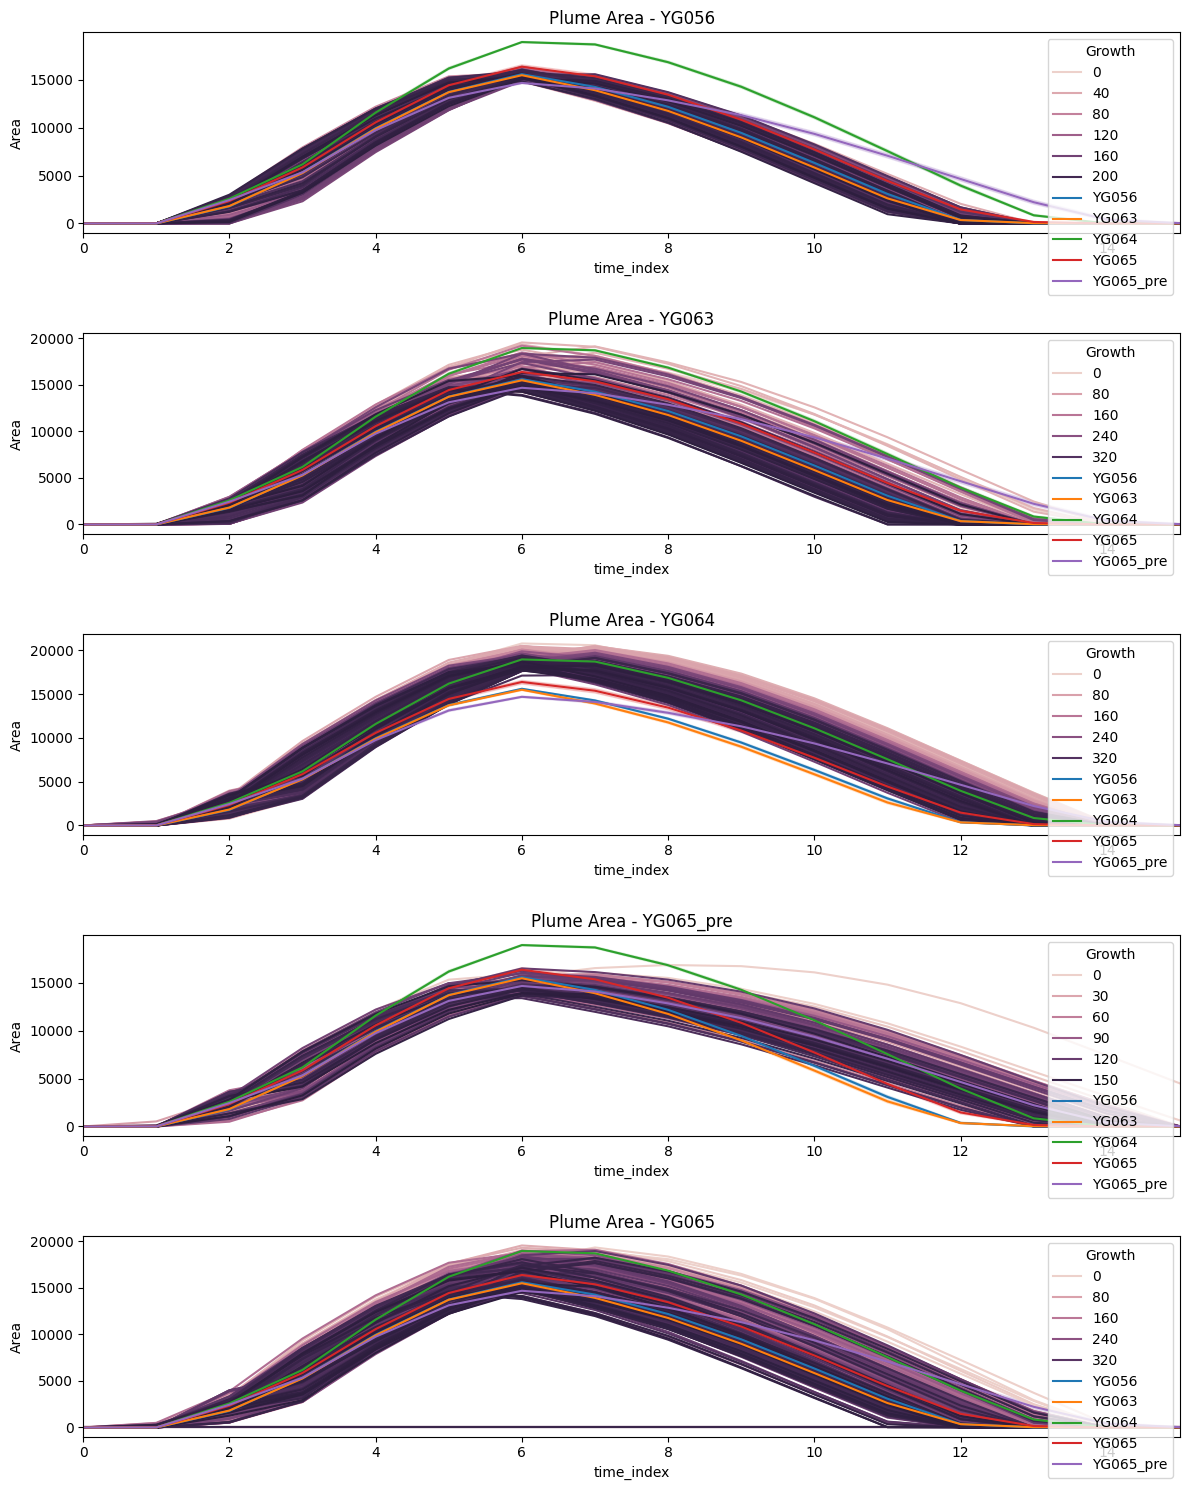

In [48]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15))

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG056'], ax=axes[0])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[0])
axes[0].set_title('Plume Area - YG056')
axes[0].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG063'], ax=axes[1])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[1])
axes[1].set_title('Plume Area - YG063')
axes[1].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG064'], ax=axes[2])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[2])
axes[2].set_title('Plume Area - YG064')
axes[2].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG065_pre'], ax=axes[3])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[3])
axes[3].set_title('Plume Area - YG065_pre')
axes[3].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_frame_metrics_200[df_frame_metrics_200['Growth']=='YG065'], ax=axes[4])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_frame_metrics_200, ax=axes[4])
axes[4].set_title('Plume Area - YG065')
axes[4].set_xlim(0, 15)

plt.tight_layout()
plt.show()

#### heatmap

C:\Users\yig319\AppData\Local\Temp\ipykernel_48564\2980832415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plume_all_200_YG065['plume_index'] = df_plume_all_200_YG065['plume_index'] + df_plume_all_200_YG065_pre['plume_index'].max()+1


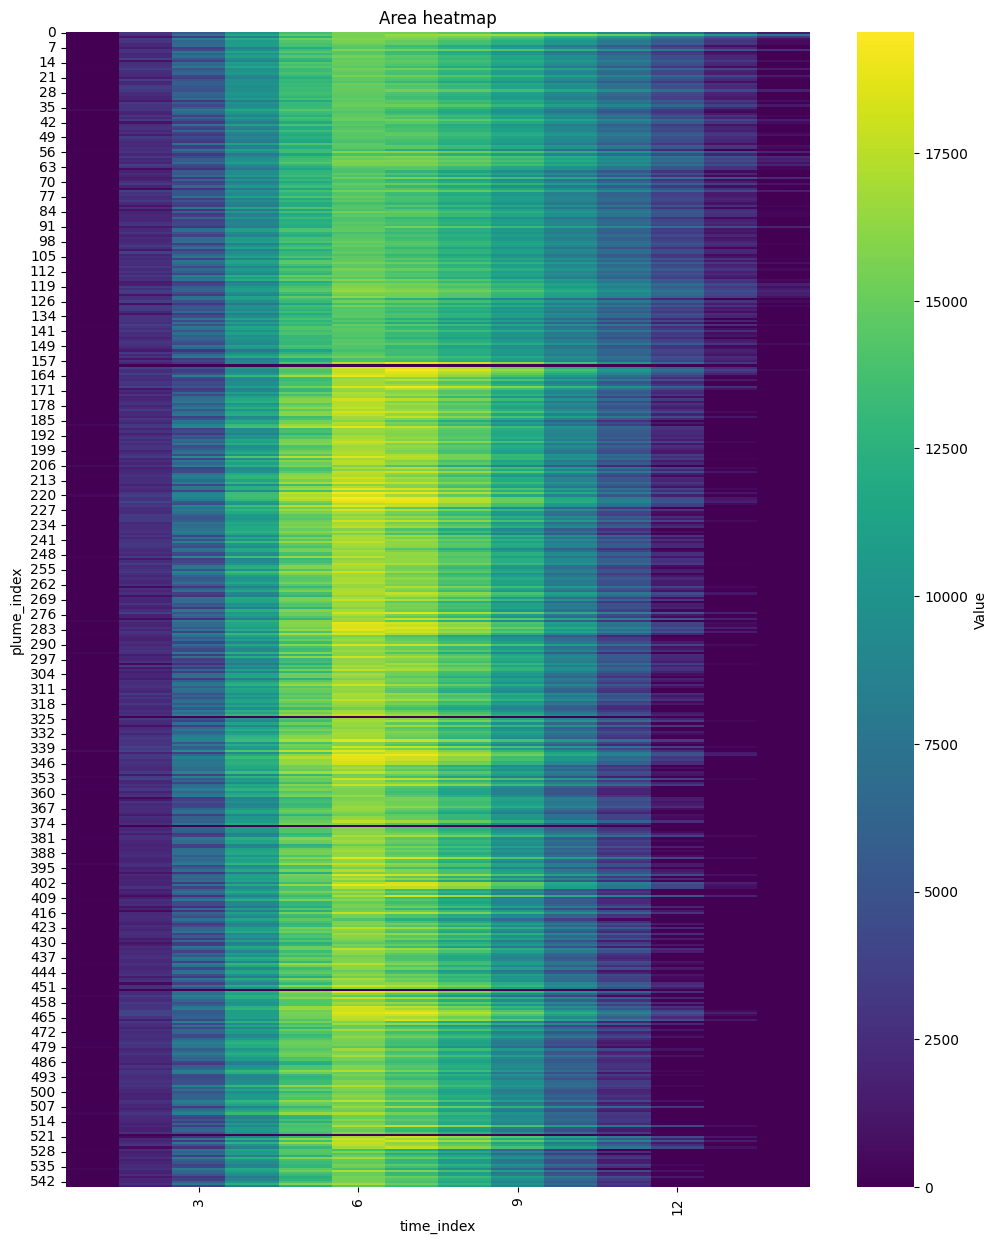

In [45]:
df_frame_level_metrics_200 = df_frame_level_metrics[df_frame_level_metrics['Threshold']=='200']

df_frame_level_metrics_200_YG065_pre = df_frame_level_metrics_200[df_frame_level_metrics_200['Growth']=='YG065_pre']
df_frame_level_metrics_200_YG065 = df_frame_level_metrics_200[df_frame_level_metrics_200['Growth']=='YG065']
df_frame_level_metrics_200_YG065['plume_index'] = df_frame_level_metrics_200_YG065['plume_index'] + df_frame_level_metrics_200_YG065_pre['plume_index'].max()+1
df_frame_level_metrics_200_YG065_all = pd.concat([df_frame_level_metrics_200_YG065_pre, df_frame_level_metrics_200_YG065], ignore_index=True)

df_pivot = df_frame_level_metrics_200_YG065_all.pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(12, 15))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

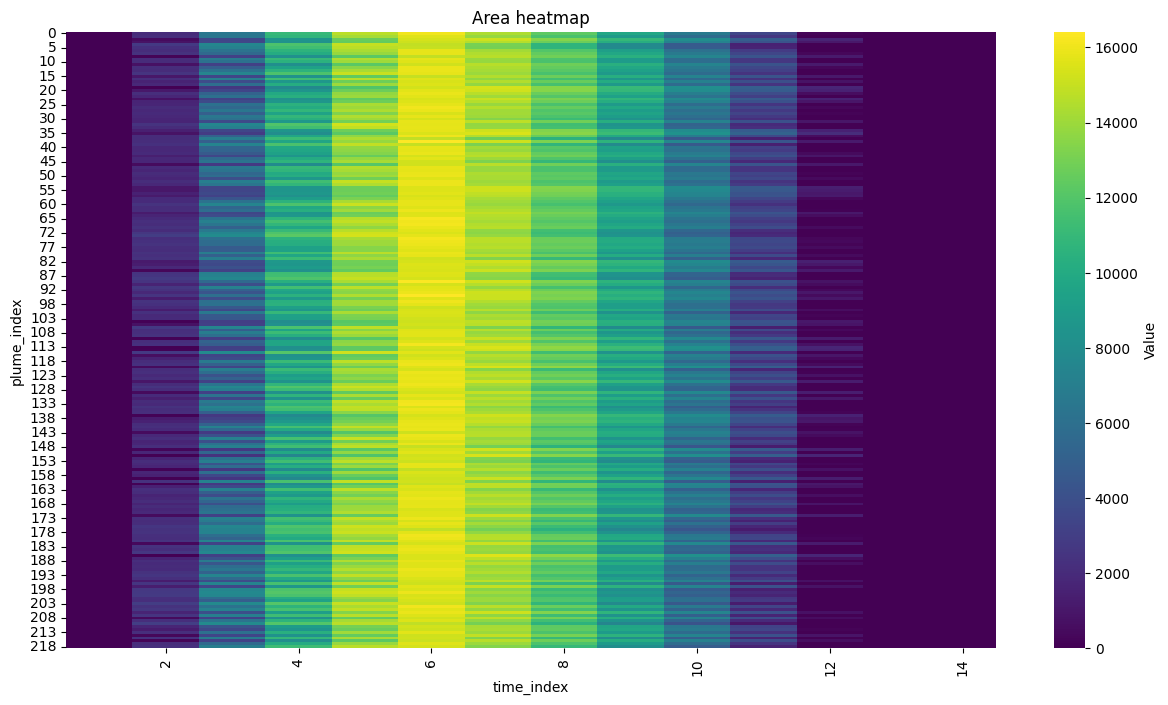

In [49]:
df_pivot = df_plume_all_200[df_plume_all_200['Growth']=='YG056'].pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

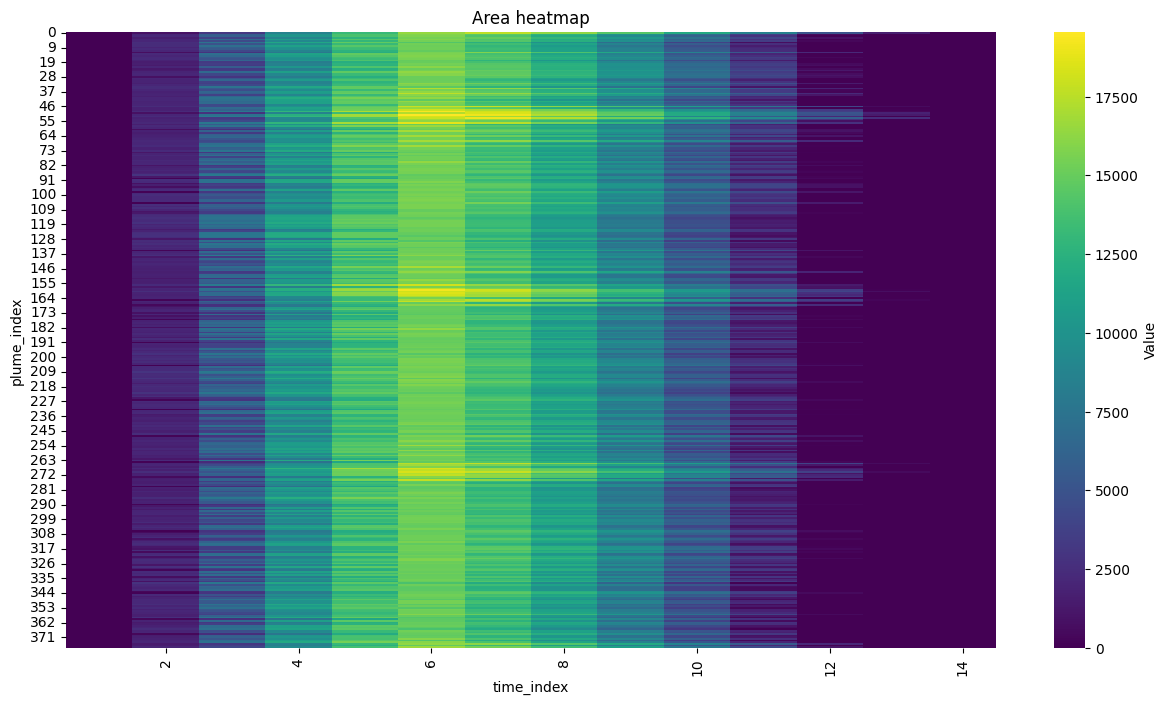

In [50]:
df_pivot = df_plume_all_200[df_frame_level_metrics_200['Growth']=='YG063'].pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

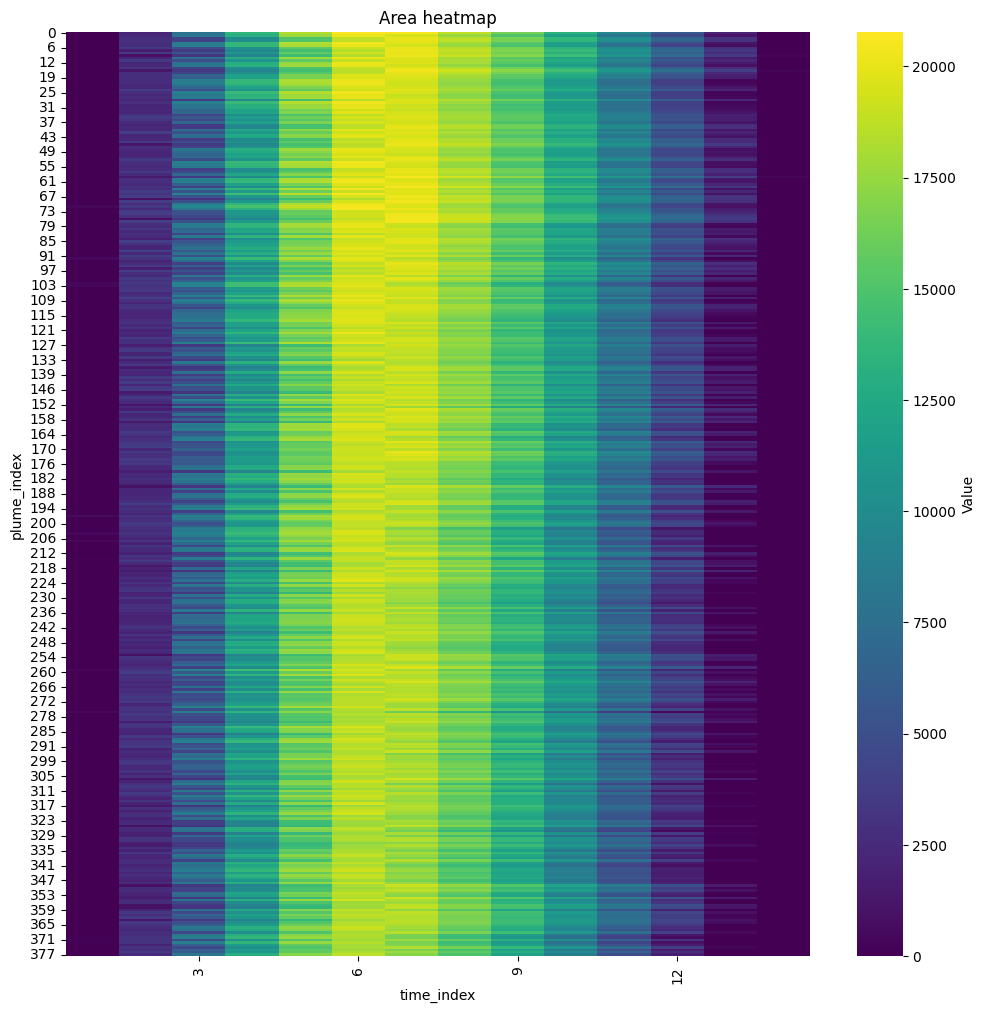

In [42]:
df_pivot = df_plume_all_200[df_plume_all_200['Growth']=='YG064'].pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(12, 12))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

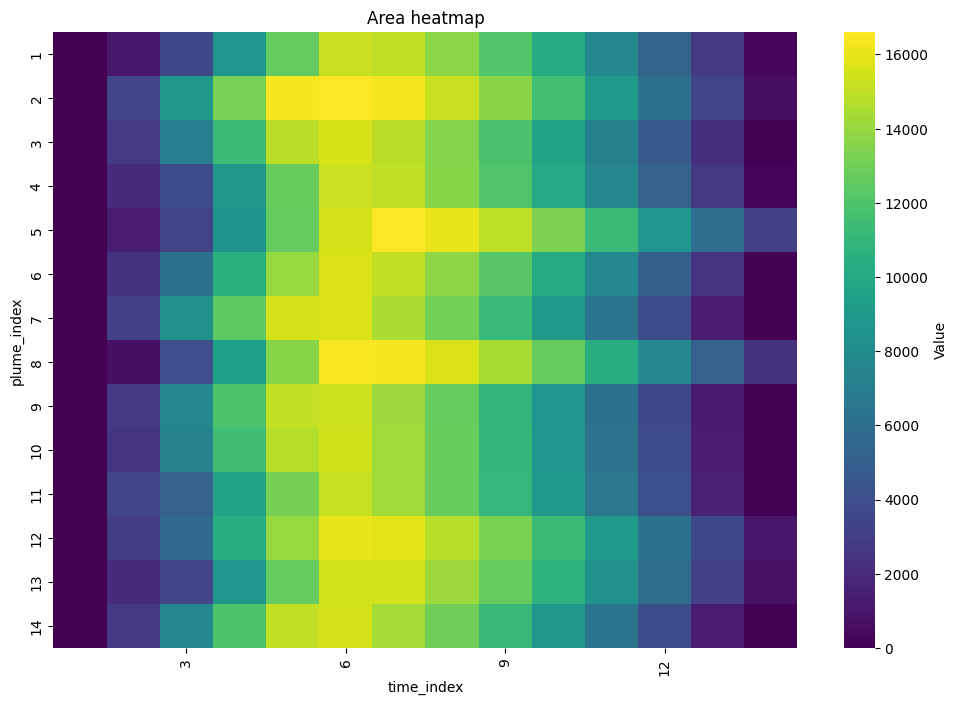

In [41]:
df_pivot = df_plume_all_200[df_plume_all_200['Growth']=='YG065'].pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

C:\Users\yig319\AppData\Local\Temp\ipykernel_62260\3866860383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plume_all_200_YG065['plume_index'] = df_plume_all_200_YG065['plume_index'] + df_plume_all_200_YG064['plume_index'].max()


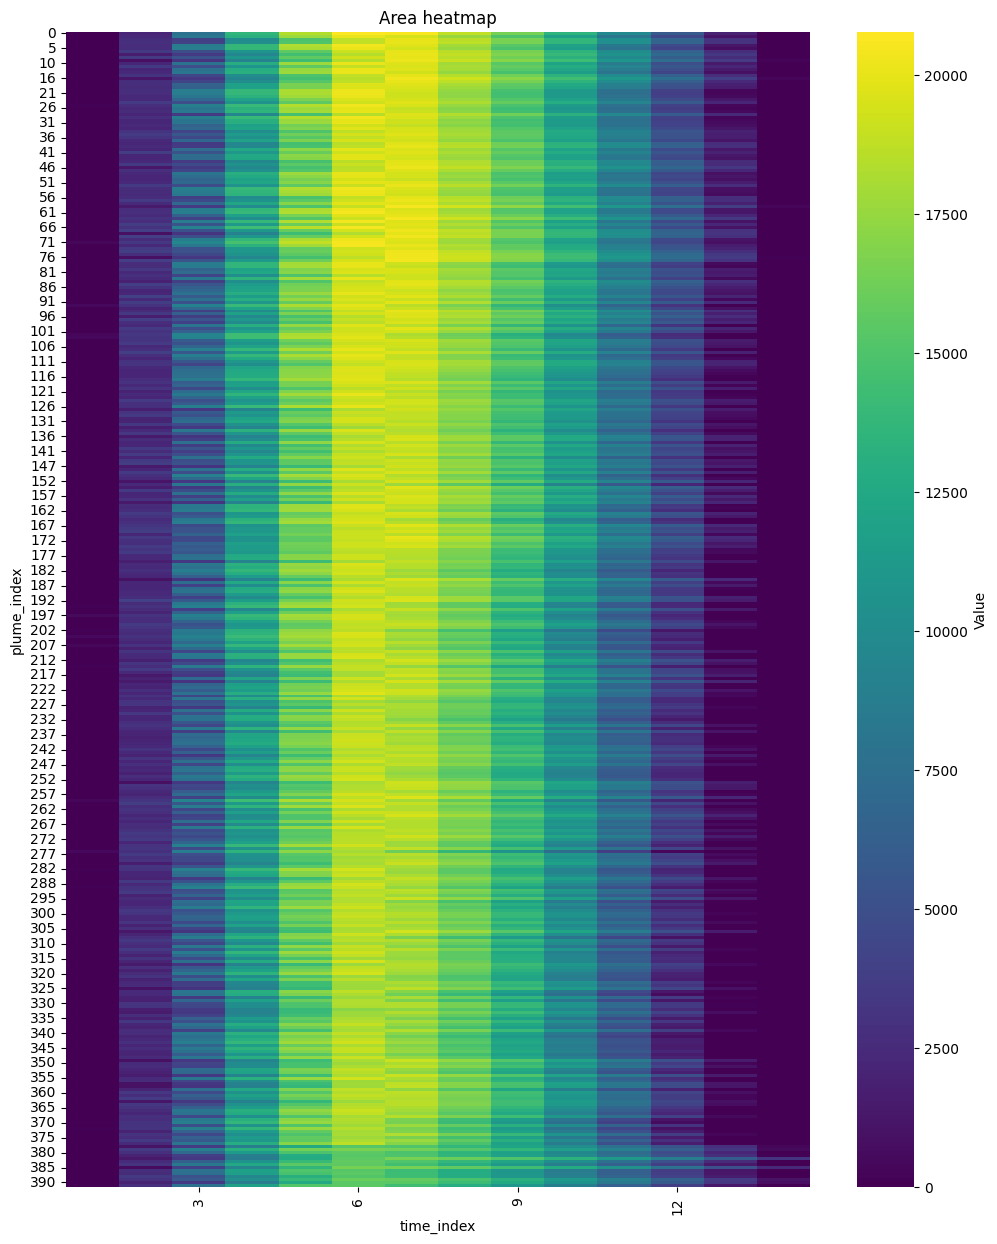

In [43]:
df_plume_all_200_YG064 = df_plume_all_200[df_plume_all_200['Growth']=='YG064']
df_plume_all_200_YG065 = df_plume_all_200[df_plume_all_200['Growth']=='YG065']
df_plume_all_200_YG065['plume_index'] = df_plume_all_200_YG065['plume_index'] + df_plume_all_200_YG064['plume_index'].max()
df_plume_all_200_YG064_065 = pd.concat([df_plume_all_200_YG064, df_plume_all_200_YG065])

df_pivot = df_plume_all_200_YG064_065.pivot(index="plume_index", columns="time_index", values="Area")
plt.figure(figsize=(12, 15))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("time_index")
plt.ylabel("plume_index")
plt.title("Area heatmap")
plt.xlim(1, 15)
plt.show()

In [ ]:
# Use a heatmap to visualize value trends across plumes and frames
plt.figure(figsize=(10, 6))
sns.heatmap(df_plume_all, cmap='viridis', cbar_kws={'label': 'Value'})
plt.xlabel("Frame")
plt.ylabel("Plume")
plt.title("Plume vs Frame Heatmap")

plt.show()